In [1]:
# Install required libraries
!pip install pillow
!pip install kaggle
!pip install glob2


In [2]:
from google.colab import files


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

!unzip celeba-dataset.zip -d ./input/


Streaming output truncated to the last 5000 lines.
  inflating: ./input/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: ./input/img_align_celeba/img_align_celeba/197618.jpg

In [4]:
import os
import glob
import numpy as np
from PIL import Image


In [5]:
dataset_dir = "./input/img_align_celeba/img_align_celeba"

image_paths = glob.glob(os.path.join(dataset_dir, '*.jpg'))

image_paths = image_paths[:20000]

def load_and_preprocess_real_images(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.crop((0, 20, 178, 198))
    img = img.resize(target_size)
    img = np.array(img)/127.5 - 1
    return img

dataset = np.array([load_and_preprocess_real_images(img_path) for img_path in image_paths])

print(dataset.shape)


(20000, 64, 64, 3)


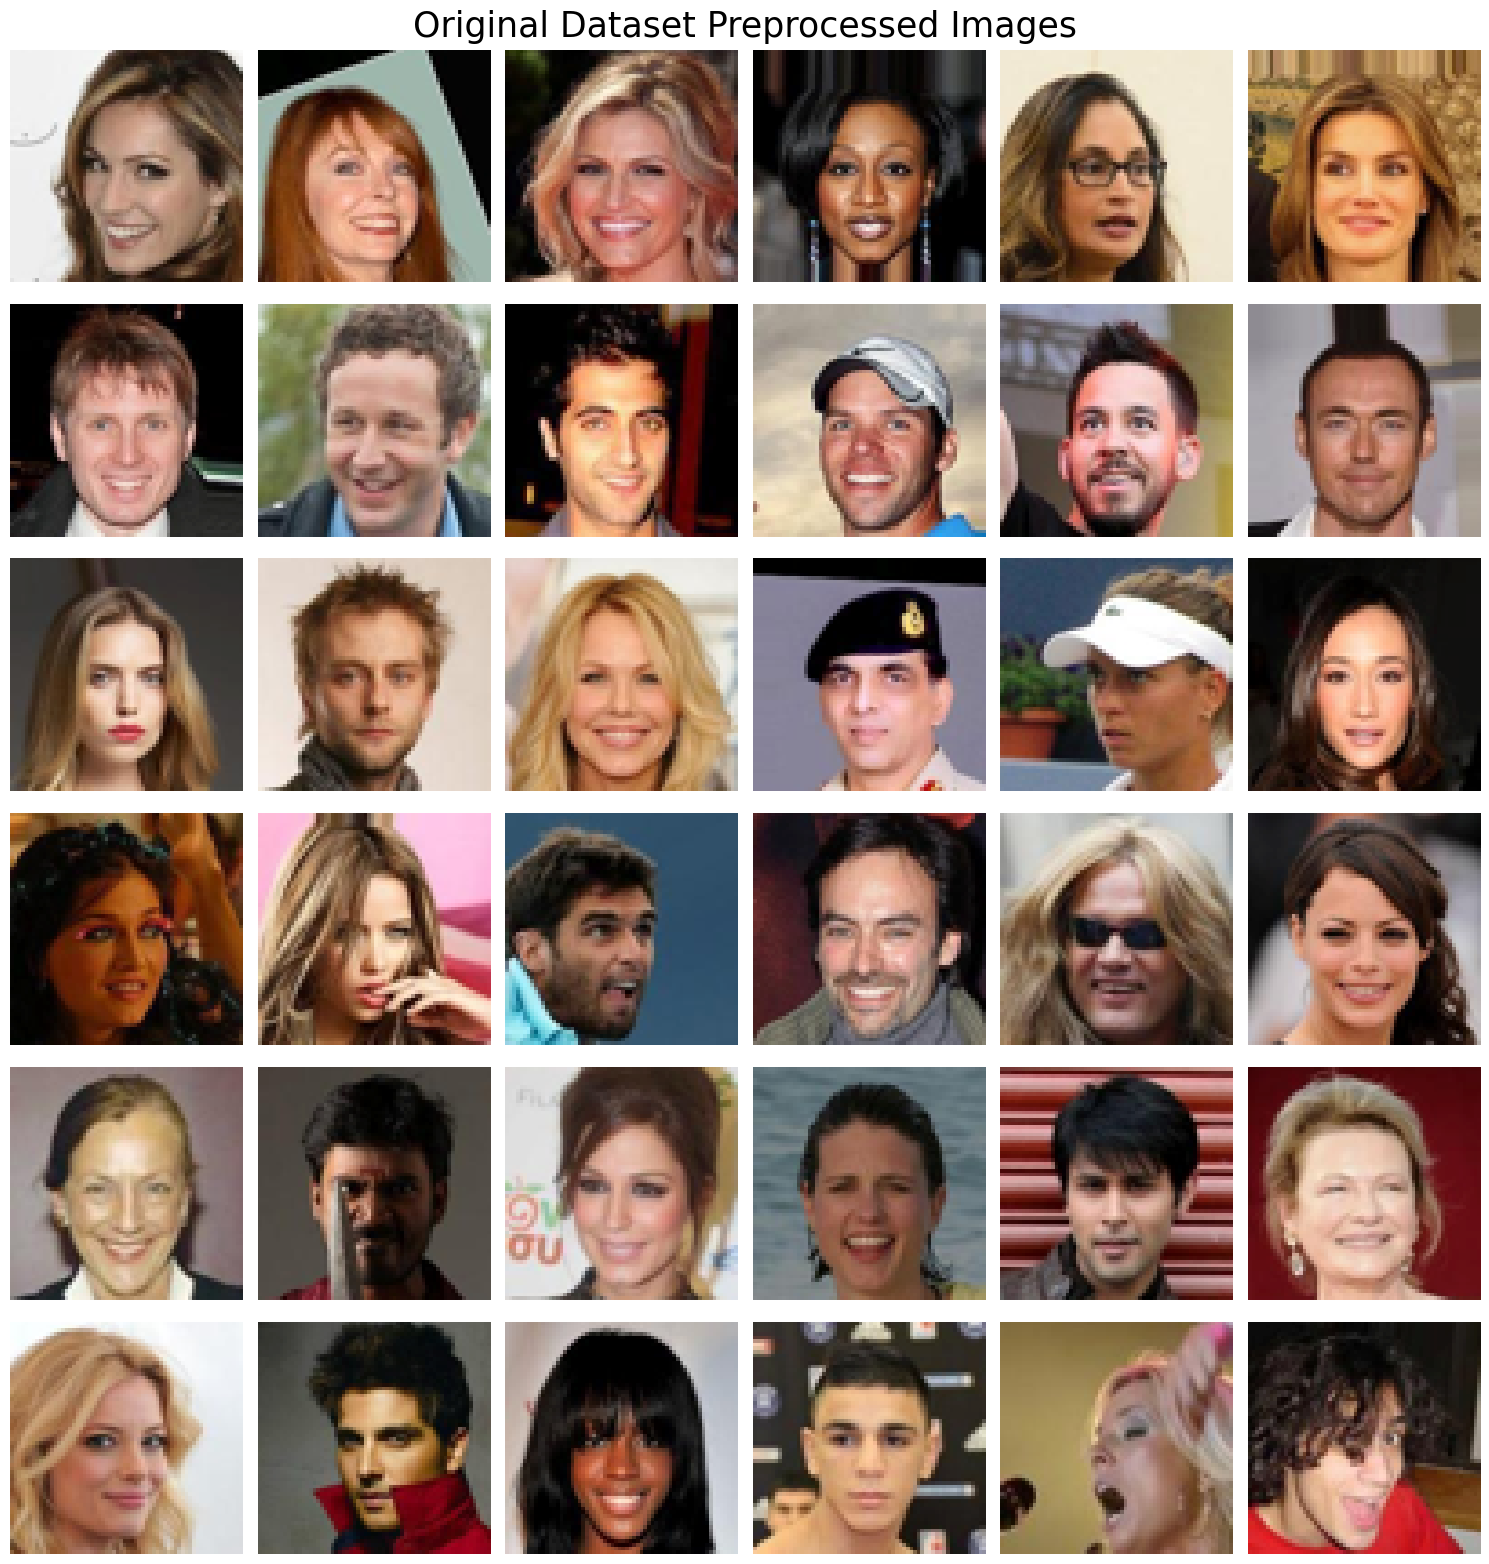

In [6]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(6, 6, figsize=(15, 16))

for i, ax in enumerate(axes.flat):
    img = dataset[i]
    img_rescaled = (img + 1) / 2
    ax.imshow(img_rescaled)
    ax.axis('off')

fig.suptitle('Original Dataset Preprocessed Images', fontsize=25)

plt.tight_layout()
plt.show()

In [7]:
from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
def build_discriminator(image_shape=(64, 64, 3)):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(256, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(256, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(512, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         5

In [8]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
def build_generator(latent_dim, channels=3):
    model = Sequential()
    model.add(Dense(16 * 16 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16, 16, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, (4, 4), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(channels, (8, 8), activation='tanh', padding='same'))

    return model
generator = build_generator(100)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             3309568   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                           

In [9]:
def build_gan(generator, discriminator):
    discriminator.trainable = False

    model = Sequential()

    model.add(generator)

    model.add(discriminator)

    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [10]:
from numpy.random import randint
from numpy import ones, zeros
from numpy.random import randn
def generate_real_samples(dataset, num_samples):
    sample_indices = randint(0, dataset.shape[0], num_samples)
    X = dataset[sample_indices]
    y = ones((num_samples, 1))
    return X, y

In [11]:
def generate_noise_samples(num_samples, noise_dim):
    X_noise = randn(noise_dim * num_samples)
    X_noise = X_noise.reshape(num_samples, noise_dim)
    return X_noise

In [12]:
def generate_fake_samples(generator, noise_dim, num_samples):
    X_noise = generate_noise_samples(num_samples, noise_dim)
    X = generator.predict(X_noise)
    y = zeros((num_samples, 1 ))
    return X, y

In [13]:
def generate_images(epoch, generator, num_samples=6, noise_dim=100):

    X_noise = generate_noise_samples(num_samples, noise_dim)

    X = generator.predict(X_noise, verbose=0)

    X = (X + 1) / 2

    return X

In [14]:
def display_saved_images(saved_images, display_frequency):

    for epoch, images in enumerate(saved_images):
        fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
        for i, img in enumerate(images):
            axes[i].imshow(img)
            axes[i].axis('off')
        fig.suptitle(f"Generated Images at Epoch {epoch*display_frequency + 1}", fontsize=22)
        plt.tight_layout()
        plt.show()

In [15]:
def plot_generated_images(epoch, generator, num_samples=6, noise_dim=100, figsize=(15, 3)):


    X_noise = generate_noise_samples(num_samples, noise_dim)

    X = generator.predict(X_noise, verbose=0)

    X = (X + 1) / 2

    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i in range(num_samples):
        axes[i].imshow(X[i])
        axes[i].axis('off')

    fig.suptitle(f"Generated Images at Epoch {epoch+1}", fontsize=22)
    plt.tight_layout()
    plt.show()

In [16]:
def train(generator_model, discriminator_model, gan_model, dataset, noise_dimension,
          num_epochs=100, batch_size=128, display_frequency=10, verbose=1):

    saved_images_for_epochs = []


    batches_per_epoch = int(dataset.shape[0] / batch_size)


    half_batch_size   = int(batch_size / 2)


    for epoch in range(num_epochs):

        for batch_num in range(batches_per_epoch):


            real_images, real_labels    = generate_real_samples(dataset, half_batch_size)

            dsr_loss_real, dsr_acc_real = discriminator_model.train_on_batch(real_images, real_labels)

            fake_images, fake_labels    = generate_fake_samples(generator_model, noise_dimension, half_batch_size)

            dsr_loss_fake, dsr_acc_fake = discriminator_model.train_on_batch(fake_images, fake_labels)

            dsr_loss = 0.5 * np.add(dsr_loss_real, dsr_loss_fake)
            dsr_acc  = 0.5 * np.add(dsr_acc_real, dsr_acc_fake)

            gan_noise  = generate_noise_samples(batch_size, noise_dimension)
            gan_labels = np.ones((batch_size, 1))

            gen_loss, _ = gan_model.train_on_batch(gan_noise, gan_labels)

            if verbose:
                print(f"[ Epoch: {epoch+1} , Batch: {batch_num+1} ] --> [ Discriminator Loss : {dsr_loss:.6f} , Discriminator Accuracy: {100*dsr_acc:.2f}% ] [ Generator Loss: {gen_loss:.6f} ]")


        if epoch % display_frequency == 0:
            generated_images_for_epoch = generate_images(epoch, generator_model)
            saved_images_for_epochs.append(generated_images_for_epoch)

            plot_generated_images(epoch, generator_model)

    return saved_images_for_epochs

2/2 [==============================] - 0s 4ms/step


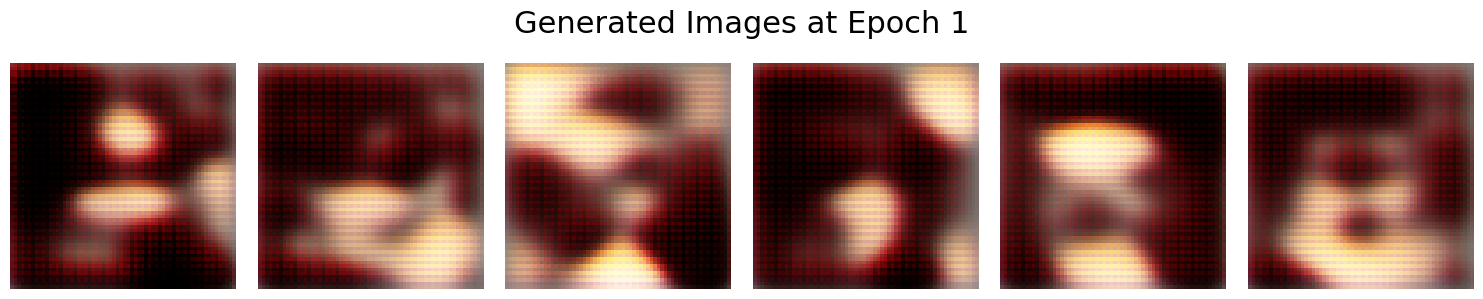

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step


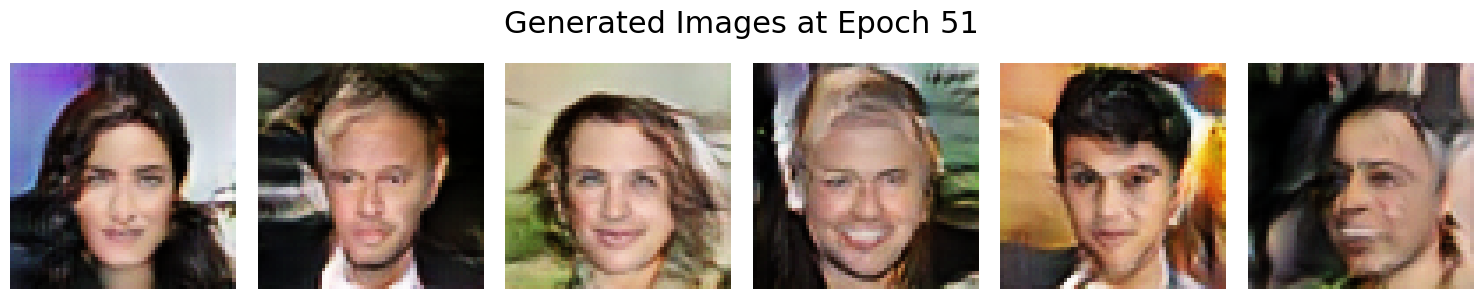

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step


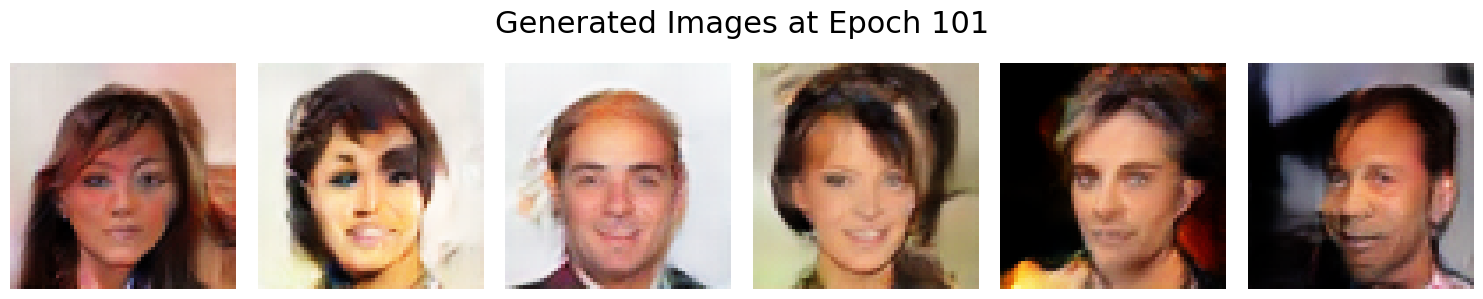

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step


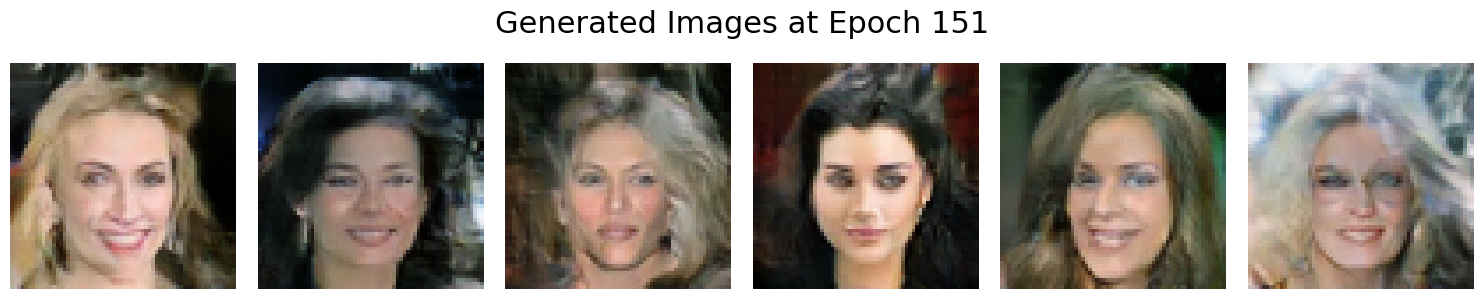

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step


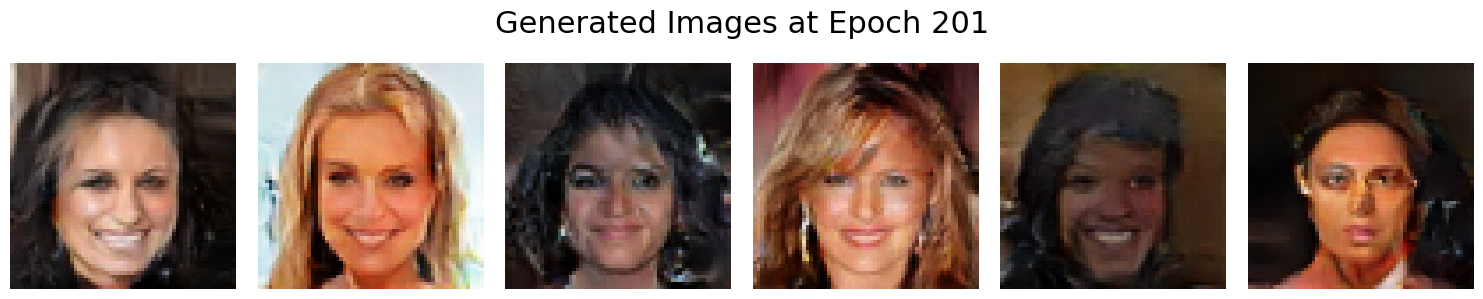

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step


In [17]:
noise_dimension = 100

discriminator = build_discriminator()

generator = build_generator(noise_dimension)

gan_model = build_gan(generator, discriminator)

saved_images = train(generator, discriminator, gan_model, dataset, noise_dimension, num_epochs=250, batch_size=128, display_frequency=50, verbose=0)

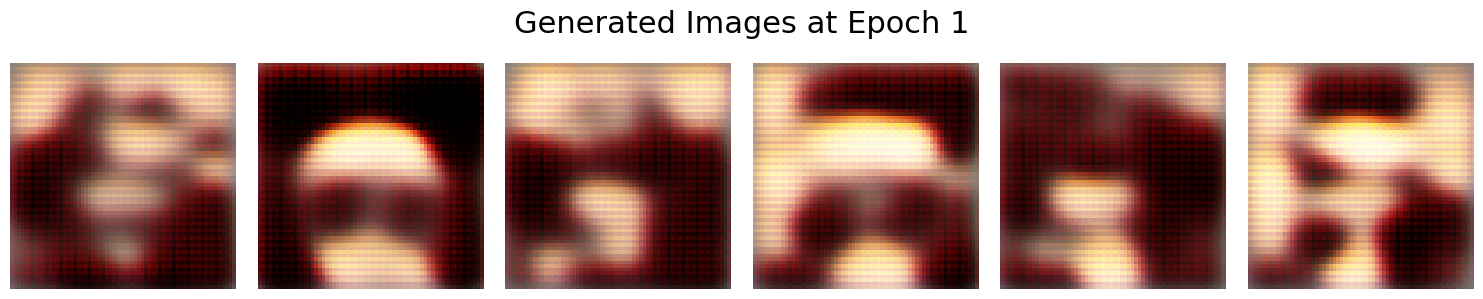

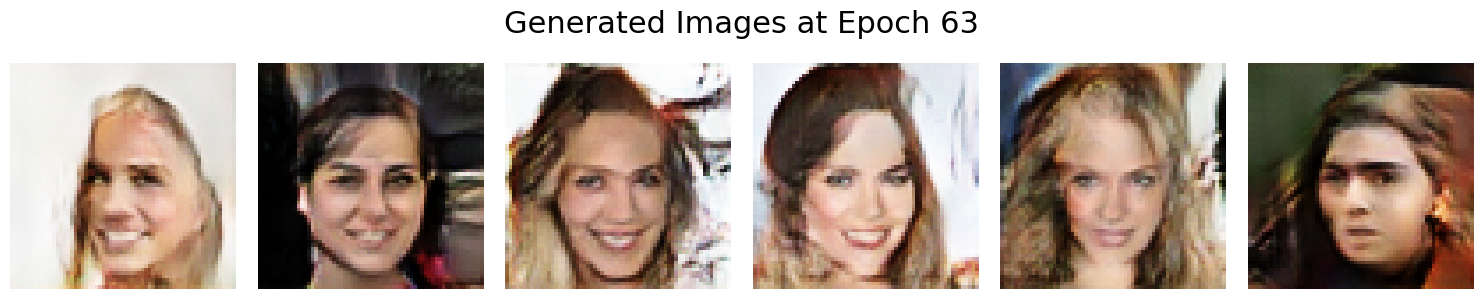

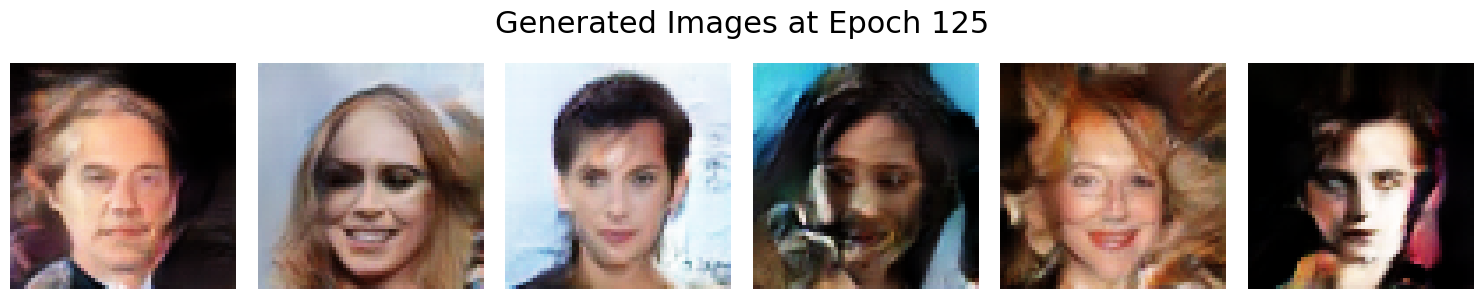

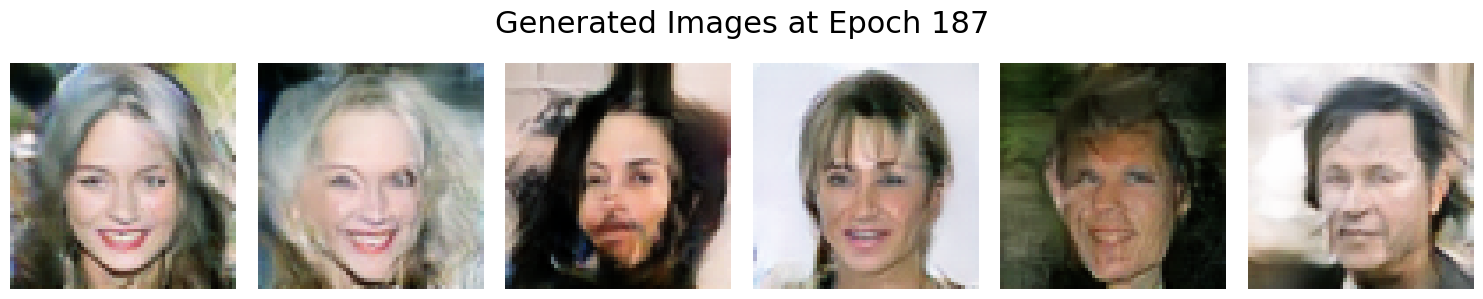

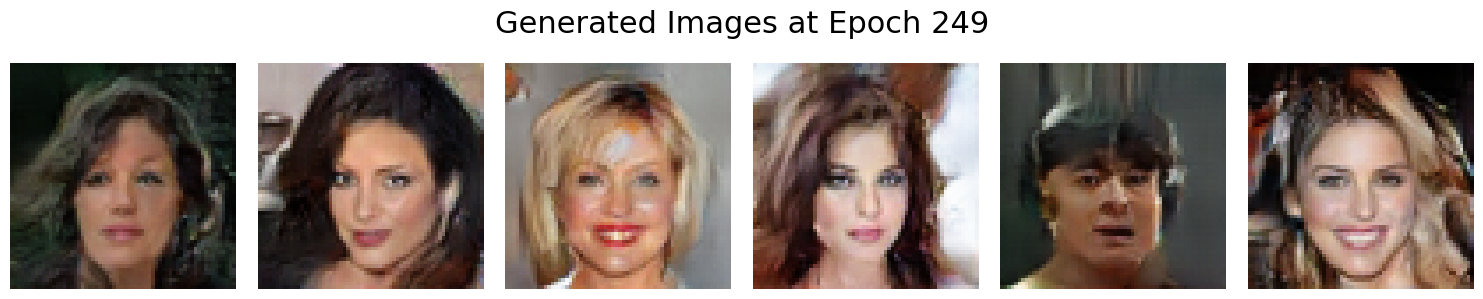

In [23]:
display_saved_images(saved_images, display_frequency=62)